In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

In [3]:
from sklearn.mixture import GaussianMixture
np.random.seed(0)
def perf_ngaussian(nb_samples, n, prop=.5, nb_iter=1000, mu_0=0., sigma_0=1.):
    # mu = np.random.uniform(-10, 10, n)
    # sigma = np.random.uniform(0, 1, n)
    # weights = np.random.uniform(0.5, 1, n)
    mu = np.array([-5, 0, 5])
    sigma = np.array([1, 1, 1])
    weights = np.array([1., 1., 1.])
    weights = weights / np.sum(weights)
    # plot the mixture of gaussians
    x = np.linspace(-10, 10, 1000)
    y = np.zeros_like(x)
    for i in range(n):
        y += weights[i] * np.exp(-(x - mu[i])**2 / (2 * sigma[i]**2))
    plt.plot(x, y)
    plt.show()

    mu_list = [mu]
    sigma_list = [sigma]
    weights_list = [weights]

    new_samples_nb = int(nb_samples * prop)
    old_samples_nb = nb_samples - new_samples_nb


    for iter in tqdm(range(nb_iter)):
        if iter == 0:
            samples = np.zeros(nb_samples)
            for i in range(nb_samples):
                k = np.random.choice(n, p=weights)
                samples[i] = np.random.normal(mu[k], sigma[k])
            old_samples = samples.copy()
        # Sample from mixture of gaussians
        new_samples = np.zeros(new_samples_nb)
        for i in range(new_samples_nb):
            # Sample a gaussian
            k = np.random.choice(n, p=weights)
            new_samples[i] = np.random.normal(mu[k], sigma[k])
        # shuffle
        np.random.shuffle(old_samples)
        old_samples_part = old_samples[:old_samples_nb]
        samples = np.concatenate((old_samples_part, new_samples))
        np.random.shuffle(samples)
        # Apply GMM on the samples
        gmm = GaussianMixture(n_components=n, covariance_type='spherical')
        gmm.fit(samples.reshape(-1, 1))
        mu_pros = gmm.means_.reshape(-1)
        # sort by mu
        sorted_indices = np.argsort(mu_pros)
        mu = mu_pros[sorted_indices]
        sigma = np.sqrt(gmm.covariances_).reshape(-1)[sorted_indices]
        weights = gmm.weights_[sorted_indices]
        mu_list.append(mu)
        sigma_list.append(sigma)
        weights_list.append(weights)

    mu_array = np.array(mu_list)
    sigma_array = np.array(sigma_list)
    weights_array = np.array(weights_list)

    return mu_array, sigma_array, weights_array

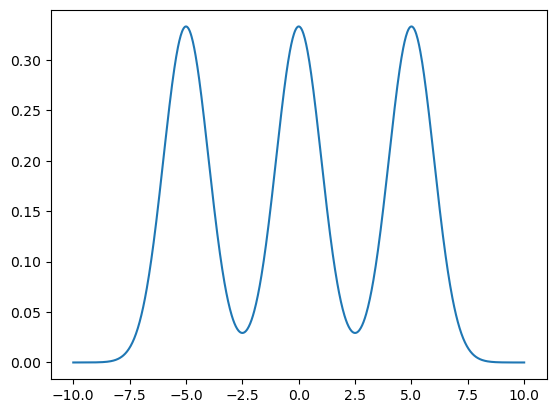

 35%|███▌      | 351/1000 [00:15<00:28, 22.48it/s]


KeyboardInterrupt: 

In [9]:
n = 3
mu_array, sigma_array, weights_array = perf_ngaussian(1000, n, prop=.9, nb_iter=1000)
# make subplots
fig, axs = plt.subplots(n, 1, figsize=(10, 10))
axs[0].set_title('mu')
axs[1].set_title('sigma')
axs[2].set_title('weights')
for i in range(n):
    axs[0].plot(mu_array[:, i])
    axs[1].plot(sigma_array[:, i])
    axs[2].plot(weights_array[:, i])
# draw horizontal line on axs[0] at -5, 0, 5
for i in range(n):
    axs[0].axhline(y=-5 + 5 * i, color='k', linestyle='dotted')
    axs[1].axhline(y=1, color='k', linestyle='dotted')
plt.show()

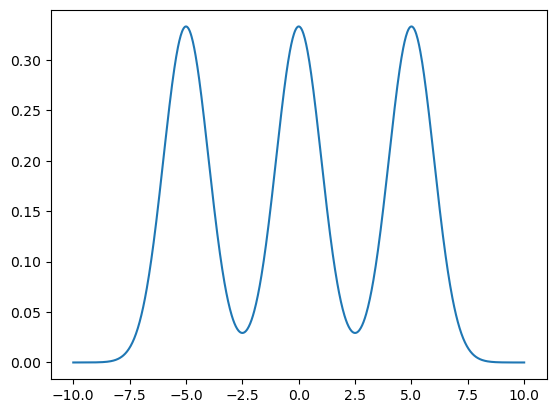

100%|██████████| 200/200 [00:02<00:00, 84.47it/s]


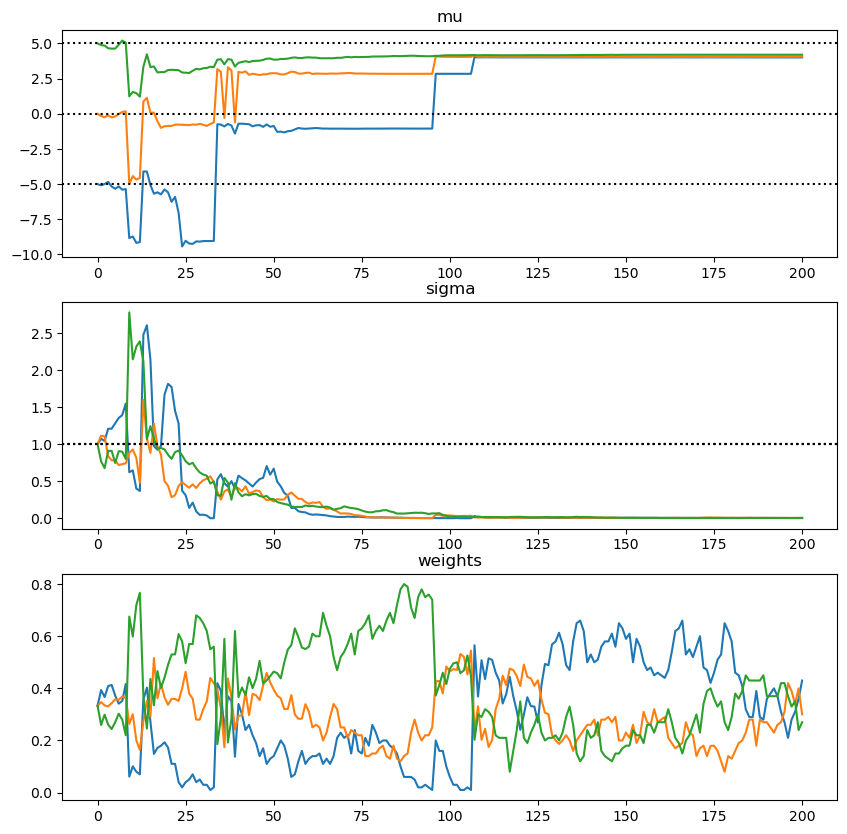

In [4]:
n = 3
mu_array, sigma_array, weights_array = perf_ngaussian(100, n, prop=1., nb_iter=200)
# make subplots
fig, axs = plt.subplots(n, 1, figsize=(10, 10))
axs[0].set_title('mu')
axs[1].set_title('sigma')
axs[2].set_title('weights')
for i in range(n):
    axs[0].plot(mu_array[:, i])
    axs[1].plot(sigma_array[:, i])
    axs[2].plot(weights_array[:, i])
# draw horizontal line on axs[0] at -5, 0, 5
for i in range(n):
    axs[0].axhline(y=-5 + 5 * i, color='k', linestyle='dotted')
    axs[1].axhline(y=1, color='k', linestyle='dotted')
plt.show()

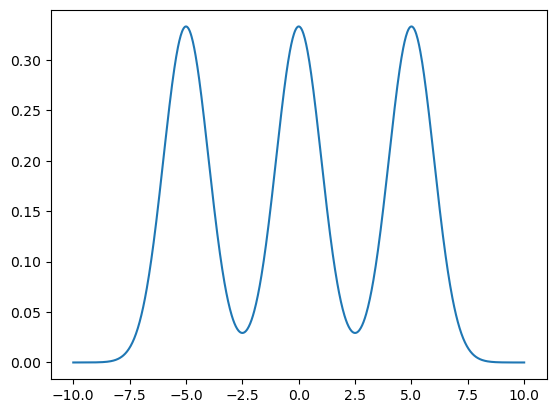

100%|██████████| 1000/1000 [00:46<00:00, 21.73it/s]


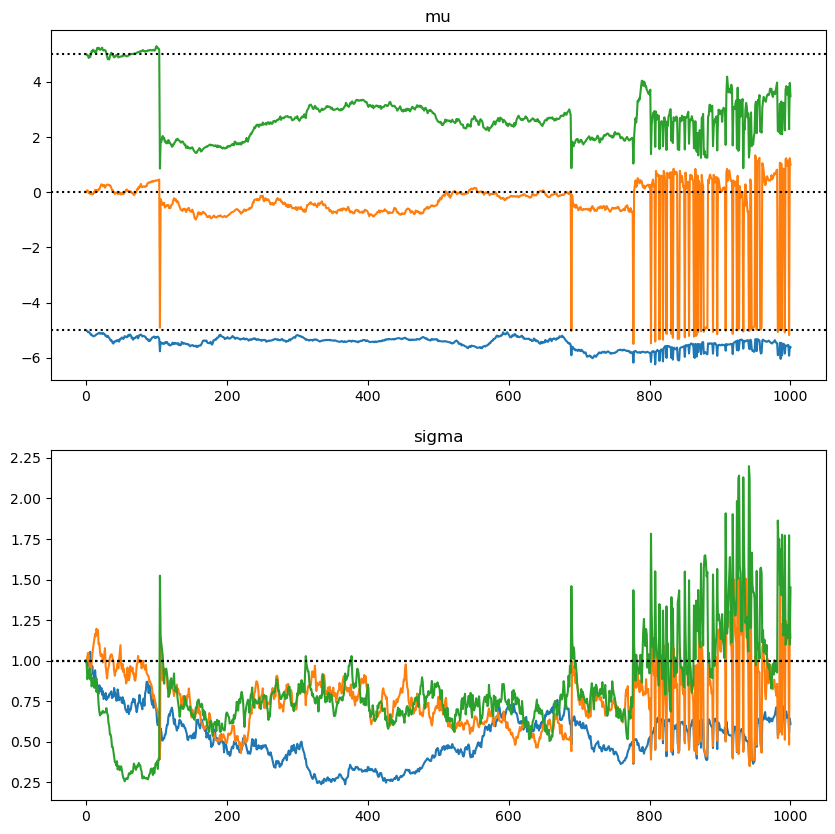

In [12]:
n = 3
mu_array, sigma_array, weights_array = perf_ngaussian(1000, n, prop=.999, nb_iter=1000)
# make subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].set_title('mu')
axs[1].set_title('sigma')
for i in range(n):
    axs[0].plot(mu_array[:, i])
    axs[1].plot(sigma_array[:, i])
# draw horizontal line on axs[0] at -5, 0, 5
for i in range(n):
    axs[0].axhline(y=-5 + 5 * i, color='k', linestyle='dotted')
    axs[1].axhline(y=1, color='k', linestyle='dotted')
plt.show()

### Fixing variance

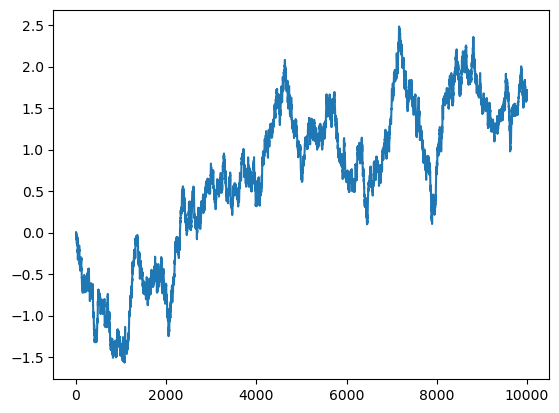

In [10]:
mu_0 = 0
mu_list = [mu_0]
nb_samples = 1000
for _ in range(10000):
    # sample nb_samples from N(mu_0, 1)
    samples = np.random.normal(mu_0, 1, nb_samples)
    # take mean
    mu_0 = np.mean(samples)
    mu_list.append(mu_0)

plt.plot(mu_list)
plt.show()

### Improvement ?

In [1]:
from perfgen.utils import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

2023-06-23 17:12:28.062580: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def test(n_samples, n_components, dim):
    samples = np.random.multivariate_normal(np.zeros(dim), np.eye(dim), n_samples)
    w1 = wasserstein_distance(samples, np.random.multivariate_normal(np.zeros(dim), np.eye(dim), n_samples))
    gmm = GaussianMixture(n_components=n_components, covariance_type='spherical')
    gmm.fit(samples)
    gen_samples = gmm.sample(n_samples)[0]
    w2 = wasserstein_distance(gen_samples, np.random.multivariate_normal(np.zeros(dim), np.eye(dim), n_samples))
    gmm = GaussianMixture(n_components=n_components, covariance_type='spherical')
    gmm.fit(gen_samples)
    gen_samples2 = gmm.sample(n_samples)[0]
    w3 = wasserstein_distance(gen_samples2, np.random.multivariate_normal(np.zeros(dim), np.eye(dim), n_samples))
    return w1, w2, w3

100%|██████████| 17/17 [00:51<00:00,  3.05s/it]


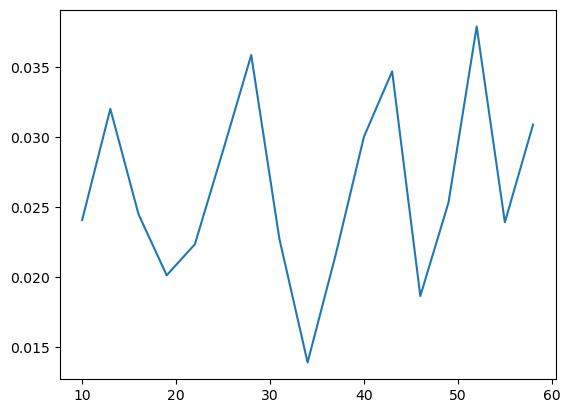

In [15]:
n_components_range = range(10, 60, 3)
n_samples = 100
dim = 1
redo = 100
impr_list = []
for n_components in tqdm(n_components_range):
    mean_improvement = 0
    for _ in range(redo):
        w1, w2, w3 = test(n_samples, n_components, dim)
        mean_improvement += w3 - w2
    mean_improvement /= redo
    impr_list.append(mean_improvement)

plt.plot(n_components_range, impr_list)